# Downloads/installs

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%capture
!pip install segment_anything
!pip install roboflow

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import glob
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

import json
import toml
import os
import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
from pycocotools.coco import COCO
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset
import logging
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.types import Device

from roboflow import Roboflow
from typing import List, Dict, Any
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

# Declarations

In [3]:
# TODO: Put your path here !!!!
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/highway'
train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"
# train = "/content/drive/MyDrive/finetunesam/train"
# test = "/content/drive/MyDrive/finetunesam/test"
# annot = "annotations.json"
#model
global batch_size
global epochs
global lr
global weight_decay
global DEVICE

# TODOD adjust, if needed!!!!
batch_size = 1
epochs = 10
lr = 0.001
weight_decay = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# loss
global alpha
global gamma
alpha = 0.8
gamma = 2

# Freeze Layera
freeze_layers = [100, 50, 10]

cuda


# Dataset

### Roboflow

In [4]:
rf = Roboflow(api_key="ZgskaiCzxYnJx1kwRctg") # Your API key here
project = rf.workspace("ktpj").project("cool_roof_detect")
version = project.version(1)
dataset = version.download("coco")
robofolder = '/content/cool_roof_detect-1'
robotrain = f"{robofolder}/train"
robovalid = f"{robofolder}/valid"
robotest = f"{robofolder}/test"
roboannot = "_annotations.coco.json"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cool_roof_detect-1 in coco:: 100%|██████████| 126/126 [00:00<00:00, 4073.62it/s]


### COCO

In [5]:
class COCODataset(Dataset):
    """
    A PyTorch Dataset to load data from a json file in COCO format.

    ...
    Attributes
    ----------
    root_dir : str
        the root directory containing the images and annotations
    annotation_file : str
        name of the json file containing the annotations (in root_dir)
    transform : callable
        a function/transform to apply to each image

    Methods
    -------
    __getitem__(idx)
        returns the image, image path, and masks for the given index
    buid_total_mask(masks)
        combines the masks into a single mask
    """


    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        # Filter out image_ids without any annotations
        self.image_ids = [image_id for image_id in self.image_ids if len(self.coco.getAnnIds(imgIds=image_id)) > 0]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        bboxes = []
        masks = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h])
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        if self.transform:
            image, masks, bboxes = self.transform(image, masks, np.array(bboxes))

        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)
        return image, image_path, torch.tensor(masks).float()

    def get_totalmask(self, masks):
        """get all masks in to one image
        ARGS:
            masks (List[Tensor]): list of masks
        RETURNS:
            total_gt (Tensor): all masks in one image

        """
        total_gt = torch.zeros_like(masks[0][0,:,:])
        for k in range(len(masks[0])):
            total_gt += masks[0][k,:,:]
        return total_gt



class ResizeAndPad:
    """
    Resize and pad images and masks to a target size.

    ...
    Attributes
    ----------
    target_size : int
        the target size of the image
    transform : ResizeLongestSide
        a transform to resize the image and masks
    """

    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, masks, bboxes):
        # Resize image and masks
        og_h, og_w, _ = image.shape
        image = self.transform.apply_image(image)
        masks = [torch.tensor(self.transform.apply_image(mask)) for mask in masks]
        image = self.to_tensor(image)

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = transforms.Pad(padding)(image)
        masks = [transforms.Pad(padding)(mask) for mask in masks]

        # Adjust bounding boxes
        bboxes = self.transform.apply_boxes(bboxes, (og_h, og_w))
        bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]

        return image, masks, bboxes


def load_datasets(img_size, trainpath, validpath, testpath, annotpath):
    """ load the training and validation datasets in PyTorch DataLoader objects
    ARGS:
        img_size (Tuple(int, int)): image size
    RETURNS:
        train_dataloader (DataLoader): training dataset
        val_dataloader (DataLoader): validation dataset

    """
    transform = ResizeAndPad(1024)
    traindata = COCODataset(root_dir=trainpath,
                        annotation_file=os.path.join(trainpath, annotpath),
                        transform=transform)
    valdata = COCODataset(root_dir=validpath,
                      annotation_file=os.path.join(validpath, annotpath),
                      transform=transform)
    testdata = COCODataset(root_dir=testpath,
                      annotation_file=os.path.join(testpath, annotpath),
                      transform=transform)
    train_dataloader = DataLoader(traindata,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=1)
    val_dataloader = DataLoader(valdata,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=1)
    test_dataloader = DataLoader(testdata,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=1)

    return train_dataloader, val_dataloader, test_dataloader



# Train functions

### Model/loss classes

In [6]:
import torch.nn as nn
class ModelSimple(nn.Module):
    """
    Wrapper for the sam model to to fine-tune the model on a new dataset

    ...
    Attributes:
    -----------
    freeze_encoder (bool): freeze the encoder weights
    freeze_decoder (bool): freeze the decoder weights
    freeze_prompt_encoder (bool): freeze the prompt encoder weights
    transform (ResizeLongestSide): resize the images to the model input size

    Methods:
    --------
    setup(): load the model and freeze the weights
    forward(images, points): forward pass of the model, returns the masks and iou_predictions
    """

    def __init__(self, freeze_encoder=True, freeze_decoder=False, freeze_prompt_encoder=True, freeze_percentage=False, percentage=1):
        super().__init__()
        self.freeze_encoder = freeze_encoder
        self.freeze_decoder = freeze_decoder
        self.freeze_prompt_encoder = freeze_prompt_encoder
        self.freeze_percentage = freeze_percentage
        self.percentage = percentage
        # we need this to make the input image size compatible with the model
        self.transform = ResizeLongestSide(1024) #This is 1024, because sam was trained on 1024x1024 images

    def setup(self):
        # You may need to adjust this path depending on how you store it.
        self.model = sam_model_registry['vit_h']('/content/drive/MyDrive/Computer Vision Project/finetunesam/sam_vit_h_4b8939.pth')
        # to speed up training time, we normally freeze the encoder and decoder
        if self.freeze_encoder:
            for param in self.model.image_encoder.parameters():
                param.requires_grad = False
        if self.freeze_prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        if self.freeze_decoder:
            for param in self.model.mask_decoder.parameters():
                param.requires_grad = False
        if self.freeze_percentage:
            all_modules = list(self.model.mask_decoder.modules())
            num_modules_unfreeze = int(len(all_modules) * self.percentage)
            for module in all_modules:
                for param in module.parameters():
                    param.requires_grad = False
            for module in all_modules[-num_modules_unfreeze:]:
                for param in module.parameters():
                    param.requires_grad = True

        self.transfrom = ResizeLongestSide(self.model.image_encoder.img_size)
    def forward(self, images):
        _, _, H, W = images.shape # batch, channel, height, width
        image_embeddings = self.model.image_encoder(images) # shape: (1, 256, 64, 64)
        # get prompt embeddings without acutally any prompts (uninformative)
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )

        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings, # sparse_embeddings shape: (1, 0, 256)
            dense_prompt_embeddings=dense_embeddings, # dense_embeddings shape: (1, 256, 256)
            multimask_output=False,
        )
        # postprocess the masks to get the final masks and resize them to the original image size
        masks = F.interpolate(
            low_res_masks, # shape: (1, 1, 256, 256)
            (H, W),
            mode="bilinear",
            align_corners=False,
        )
        # shape masks after interpolate: torch.Size([1, 1, 1024, 1024])
        return masks, iou_predictions

import torch.nn as nn
import torch.nn.functional as F
import torch

def get_totalmask(masks):
    """get all masks in to one image
    ARGS:
        masks (torch.Tensor): shape: (N, H, W) where N is the number of masks
                              masks H,W is usually 1024,1024
    RETURNS:
        total_gt (torch.Tensor): all masks in one image

    """
    total_gt = torch.zeros_like(masks[0,:,:])
    for k in range(len(masks)):
        total_gt += masks[k,:,:]
    return total_gt



class FocalLoss(nn.Module):
    """ Computes the Focal loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):

        inputs = inputs.flatten(0,2)
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE

        return focal_loss


class DiceLoss(nn.Module):
    """ Computes the Dice loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.flatten(0,2)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / \
            (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

def calculate_iou(gt_mask, pred_mask, clas=1):
    pred_mask = (pred_mask == clas) * 1
    gt_mask = (gt_mask == clas) * 1

    overlap = pred_mask * gt_mask  # Logical AND
    union = (pred_mask + gt_mask)>0  # Logical OR
    iou = overlap.sum() / float(union.sum())
    return iou


### Functions

In [7]:

def criterion(x, y):
    """ Combined dice and focal loss.
    ARGS:
        x: (torch.Tensor) the model output
        y: (torch.Tensor) the target
    RETURNS:
        (torch.Tensor) the combined loss

    """
    focal, dice = FocalLoss(), DiceLoss()
    y = y.to(DEVICE)
    x = x.to(DEVICE)
    return 20 * focal(x, y) + dice(x, y)


def train_one_epoch(model, trainloader, optimizer, epoch_idx): # , tb_writer for tensroboard
    """ Runs forward and backward pass for one epoch and returns the average
    batch loss for the epoch.
    ARGS:
        model: (nn.Module) the model to train
        trainloader: (torch.utils.data.DataLoader) the dataloader for training
        optimizer: (torch.optim.Optimizer) the optimizer to use for training
        epoch_idx: (int) the index of the current epoch
        tb_writer: (torch.utils.tensorboard.writer.SummaryWriter) the tensorboard writer
    RETURNS:
        last_loss: (float) the average batch loss for the epoch

    """
    running_loss = 0.
    for i, (image, path, masks) in enumerate(trainloader):
        image = image.to(DEVICE)
        optimizer.zero_grad()
        pred, _ = model(image)
        # print(f'pred shape: {pred.shape}')
        masks = masks[0].to(DEVICE)
        total_mask = get_totalmask(masks)
        pred = pred.to(DEVICE)
        loss = criterion(pred, total_mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    i = len(trainloader)
    last_loss = running_loss / i
    # print(f'batch_loss for batch {i}: {last_loss}')
    # tb_x = epoch_idx * len(trainloader) + i + 1
    # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.
    return last_loss


def training(model, trainloader, validloader):
    """ Trains the model for the given number of epochs."""
    bestmodel_path = ""
    # model = ModelSimple()
    # model.setup()
    # model.to(DEVICE)
    img_size = model.model.image_encoder.img_size
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_loss = float('inf')
    best_iou_loss = float('-inf')
    losses = []
    ious = []
    bestlosses = []
    bestious = []
    for epch in range(epochs): # type: ignore
        running_vloss = 0.
        iou_loss = 0.
        model.train(True)
        avg_batchloss = train_one_epoch(
            model, trainloader, optimizer, epch)
        print(f'epoch: {epch}, training loss: {avg_batchloss}')
        if not eval: # type: ignore
            continue
        with torch.no_grad():
            for i, (images, path, masks) in enumerate(validloader):
                model.to(DEVICE)
                images = images.to(DEVICE)
                masks = masks[0].to(DEVICE)
                total_mask = get_totalmask(masks)
                total_mask = total_mask.to(DEVICE)
                model.eval()
                preds, iou = model(images)
                preds = preds.to(DEVICE)
                vloss = criterion(preds, total_mask)
                running_vloss += vloss.item()
                iou_loss += iou.item()
        print(f'epoch: {epch}, validloss: {running_vloss}')
        avg_vloss = running_vloss / len(validloader)
        avg_iou = iou_loss / len(validloader)
        print(f"iou_loss: {avg_iou}")
        print("\n")
        # save model
        print(f'best valid loss: {best_valid_loss}')
        print(f'best iou loss: {best_iou_loss}')
        print("\n\n")
        losses.append(avg_vloss)
        ious.append(avg_iou)
        bestlosses.append(best_valid_loss)
        bestious.append(best_iou_loss)
        if running_vloss < best_valid_loss:
          # best_model = model
          best_valid_loss = running_vloss
        if avg_iou > best_iou_loss:
          best_model = model
          best_iou_loss = avg_iou
    return best_model, bestlosses, bestious, losses, ious
"""

# next add train function for prompting model with points (ModelAll)
# next unrelated find out how to get tensor output of masks form SamAutomaticMaskGenerator
"""

'\n\n# next add train function for prompting model with points (ModelAll)\n# next unrelated find out how to get tensor output of masks form SamAutomaticMaskGenerator\n'

# Visualisation functions

In [8]:
def image_row(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(16, 5))
    for i, ax in enumerate(axs):
        if i == 0:
            ax.imshow(images[i])
        else:
            ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
    plt.show()

def display_results(model, untrainedmodel, loader, percentile, trained=None, untrained=None):
    with torch.no_grad():
        for i, (images, path, masks) in enumerate(loader):
            images = images.to(DEVICE)
            temp = images
            masks = masks[0].to(DEVICE)
            total_mask = get_totalmask(masks)
            total_mask = total_mask.to(DEVICE)

            preds, iou = model(images)
            preds = preds.to(DEVICE)
            loss = criterion(preds, total_mask)
            probs = torch.sigmoid(preds.squeeze(1))
            probs = probs.cpu().numpy().squeeze()
            threshold = np.percentile(probs, percentile)
            probs = (probs >= threshold)
            total_mask = total_mask.cpu()

            untrainedpreds, untrainediou = untrainedmodel(images)
            untrainedpreds = untrainedpreds.to(DEVICE)
            untrainedloss = criterion(untrainedpreds, total_mask)
            untrainedprobs = torch.sigmoid(untrainedpreds.squeeze(1))
            untrainedprobs = untrainedprobs.cpu().numpy().squeeze()
            untrainedthreshold = np.percentile(untrainedprobs, percentile)
            untrainedprobs = (untrainedprobs >= untrainedthreshold)

            print("Mine")
            print(calculate_iou(total_mask.numpy(), probs.squeeze()))
            print(calculate_iou(total_mask.numpy(), untrainedprobs.squeeze()))

            print("Model")
            print(iou.item())
            print(untrainediou.item())
            print(loss.item())
            print(untrainedloss.item())

            triple_images = [temp[0].permute(1, 2, 0).cpu().numpy(), total_mask.numpy(),
                             probs, untrainedprobs]
            image_row(triple_images, ['Image', 'Ground Truth Mask', 'Trained Mask', 'Untrained mask'])


def plot_results(losses, ious):
    fig, ax1 = plt.subplots()

    # Plot losses on primary y-axis
    color1 = 'tab:blue'
    ax1.plot(losses, label="Losses", color=color1)
    ax1.set_ylabel("Loss", color=color1)

    # Create a secondary y-axis for ious
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(ious, label="Ious", color=color2)
    ax2.set_ylabel("IoU", color=color2)

    # Position the y-axis on separate sides
    ax1.yaxis.label.set_color(color1)
    ax2.yaxis.label.set_color(color2)
    ax1.tick_params(axis='y', colors=color1)
    ax2.tick_params(axis='y', colors=color2)

    # Common x-axis label
    ax1.set_xlabel("Epoch")
    plt.title("Losses and Ious")

    # Legend for both plots
    fig.tight_layout()
    fig.legend()

    # Show the plot
    plt.show()

# Initializations

In [9]:
!cp -r /content/cool_roof_detect-1/valid /content/cool_roof_detect-1/test

In [10]:
trainloader, validloader, testloader = load_datasets(1024, train, valid, test, annot)
robotrainloader, robovalidloader, robotestloader = load_datasets(1024, robotrain, robovalid, robotest, roboannot)
# Freeze percentage - 100% 50% 10% 1%
# Change loss weightage - 40:1 20:1 10:1 5:1
# change epochs - 20 10 5 1
# model = ModelSimple(freeze_percentage=True, percentage=10)
# model.setup()
# model.to(DEVICE)
# model.train()

# untrained = ModelSimple()
# untrained.setup()
# untrained.to(DEVICE)
# untrained.eval()

# sample_img = robotrainloader.dataset[1][0]
# sample_mask = robotrainloader.dataset[1][2]
# img_size = model.model.image_encoder.img_size
# print(img_size)
# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(sample_img.permute(1, 2, 0).numpy())
# axs[0].set_title('Image')
# axs[1].imshow(sample_mask[0].numpy(), cmap='gray')
# axs[1].set_title('Mask')
# plt.show()

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Expeiments

### Single run

In [ ]:
# Freeze percentage - 100% 50% 10% 1%
# Change loss weightage - 40:1 20:1 10:1 5:1
# change epochs - 20 10 5 1
model, bestlosses, bestious, losses, ious = training(model)

In [ ]:
display_results(model, untrained, validloader, 98)

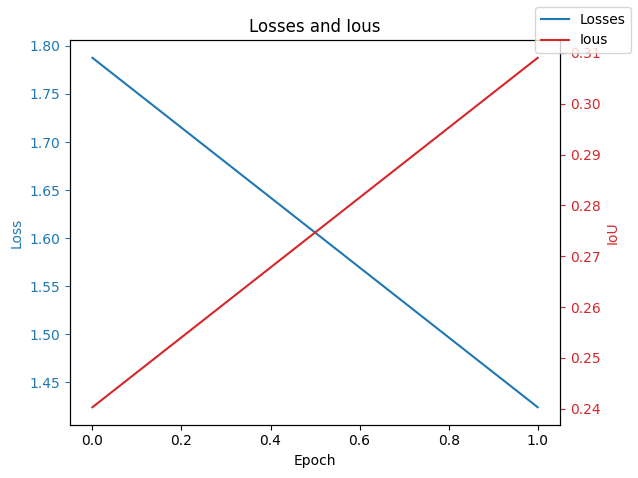

In [ ]:
plot_results(losses, ious)

### Loop run - desert

In [16]:
untrained = ModelSimple()
untrained.setup()
untrained.to(DEVICE)
untrained.eval()
print("Done")

Done


In [17]:
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/desert'
train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"

trainloader, validloader, testloader = load_datasets(1024, train, valid, test, annot)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [18]:
for i in freeze_layers:
    print(f"----------- Freeze percentage {i} (Only the last nth percentage of weights are trainable)-------------")
    model = ModelSimple(freeze_percentage=True, percentage=i)
    model.setup()
    model.to(DEVICE)
    model.train()

    model, bestlosses, bestious, losses, ious = training(model, trainloader, validloader)
    print(f"Regular ious: {ious}")
    print(f"Best ious: {bestious}")
    display_results(model, untrained, validloader, 82)
    if i in [100, 25, 1]:
        display_results(model, untrained, robovalidloader, 82)
    plot_results(losses, ious)
    print("-------------------------------------------------------------------------------------------------------")

Output hidden; open in https://colab.research.google.com to view.

### Loop run - construction

In [19]:
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/construction'
train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"

trainloader, validloader, testloader = load_datasets(1024, train, valid, test, annot)

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


In [20]:
for i in freeze_layers:
    print(f"----------- Freeze percentage {i} (Only the last nth percentage of weights are trainable)-------------")
    model = ModelSimple(freeze_percentage=True, percentage=i)
    model.setup()
    model.to(DEVICE)
    model.train()

    model, bestlosses, bestious, losses, ious = training(model, trainloader, validloader)
    print(f"Regular ious: {ious}")
    print(f"Best ious: {bestious}")
    display_results(model, untrained, validloader, 82)
    if i in [100, 25, 1]:
        display_results(model, untrained, robovalidloader, 82)
    plot_results(losses, ious)
    print("-------------------------------------------------------------------------------------------------------")

Output hidden; open in https://colab.research.google.com to view.

### Loop run - highway

In [21]:
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/highway'
train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"

trainloader, validloader, testloader = load_datasets(1024, train, valid, test, annot)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [22]:
for i in freeze_layers:
    print(f"----------- Freeze percentage {i} (Only the last nth percentage of weights are trainable)-------------")
    model = ModelSimple(freeze_percentage=True, percentage=i)
    model.setup()
    model.to(DEVICE)
    model.train()

    model, bestlosses, bestious, losses, ious = training(model, trainloader, validloader)
    print(f"Regular ious: {ious}")
    print(f"Best ious: {bestious}")
    display_results(model, untrained, validloader, 82)
    if i in [100, 25, 1]:
        display_results(model, untrained, robovalidloader, 82)
    plot_results(losses, ious)
    print("-------------------------------------------------------------------------------------------------------")

Output hidden; open in https://colab.research.google.com to view.

# LORA

In [11]:
# changes
# change config
# Freeze decoder

%%capture
!pip install poetry
!git clone https://github.com/MathieuNlp/Sam_LoRA.git
%cd Sam_LoRA

In [12]:
def delete_files_in_folder(folder_path):
    # List all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if it is a file and not a directory
        if os.path.isfile(file_path):
            os.remove(file_path)  # Delete the file

In [13]:
dat = "all" # Storage folder for results
delete_files_in_folder("/content/Sam_LoRA/dataset/test/images")
delete_files_in_folder("/content/Sam_LoRA/dataset/test/masks")
delete_files_in_folder("/content/Sam_LoRA/dataset/train/images")
delete_files_in_folder("/content/Sam_LoRA/dataset/train/masks")
delete_files_in_folder("/content/Sam_LoRA/lora_weights")

In [14]:
# Test images are comign with shape of H x W x 4 for some reason
for i, (image, path, masks) in enumerate(validloader):
    img = image[0].permute(1, 2, 0).numpy()
    # plt.imshow(img)
    # plt.show()
    msk = get_totalmask(masks[0]).numpy()
    # plt.imshow(msk, cmap="gray")
    # plt.show()
    plt.imsave(f"/content/Sam_LoRA/dataset/test/images/{dat}{i}.jpg", img)
    plt.imsave(f"/content/Sam_LoRA/dataset/test/masks/{dat}{i}.jpg", msk)

for i, (image, path, masks) in enumerate(trainloader):
    img = image[0].permute(1, 2, 0).numpy()
    # plt.imshow(img)
    # plt.show()
    msk = get_totalmask(masks[0]).numpy()
    # plt.imshow(msk, cmap="gray")
    # plt.show()
    plt.imsave(f"/content/Sam_LoRA/dataset/train/images/{dat}{i}.jpg", img)
    plt.imsave(f"/content/Sam_LoRA/dataset/train/masks/{dat}{i}.jpg", msk)

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


In [15]:
%%capture
!poetry config virtualenvs.in-project false
!poetry install --all-extras
!poetry run pip install --upgrade torch torchvision gradio safetensors opencv-python monai
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [18]:
!poetry run python train.py

100% 15/15 [00:06<00:00,  2.45it/s]
EPOCH: 0
Mean loss training: 1.1312083800633748


In [19]:
import torch
import numpy as np
from src.segment_anything import build_sam_vit_b, SamPredictor, sam_model_registry
from src.processor import Samprocessor
from src.lora import LoRA_sam
from PIL import Image
import matplotlib.pyplot as plt
import src.utils as utils
from PIL import Image, ImageDraw
import yaml
import json
from torchvision.transforms import ToTensor

"""
This file is used to plots the predictions of a model (either baseline or LoRA) on the train or test set. Most of it is hard coded so I would like to explain some parameters to change
referencing by lines :
line 22: change the rank of lora; line 98: Do inference on train (inference_train=True) else on test; line 101 and 111 is_baseline arguments in fuction: True to use baseline False to use LoRA model.
"""
sam_checkpoint = "sam_vit_b_01ec64.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = build_sam_vit_b(checkpoint=sam_checkpoint)
rank = 512
sam_lora = LoRA_sam(sam, rank)
sam_lora.load_lora_parameters(f"./lora_rank{rank}.safetensors")
model = sam_lora.sam


def inference_model(sam_model, img, mask, is_baseline=False):
    if is_baseline == False:
        model = sam_model.sam
        rank = sam_model.rank
    else:
        model = build_sam_vit_b(checkpoint=sam_checkpoint)

    model.eval()
    model.to(device)
    image = img
    # mask = mask.convert('1')
    ground_truth_mask =  np.array(mask)
    box = utils.get_bounding_box(ground_truth_mask)

    predictor = SamPredictor(model)
    predictor.set_image(np.array(image))
    masks, iou_pred, low_res_iou = predictor.predict(
        box=np.array(box),
        multimask_output=False,
    )

    return masks

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


torch.Size([1024, 1024, 3])


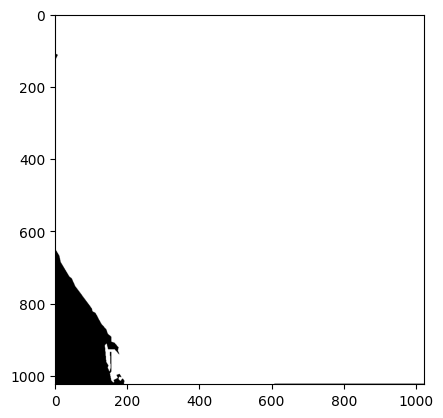

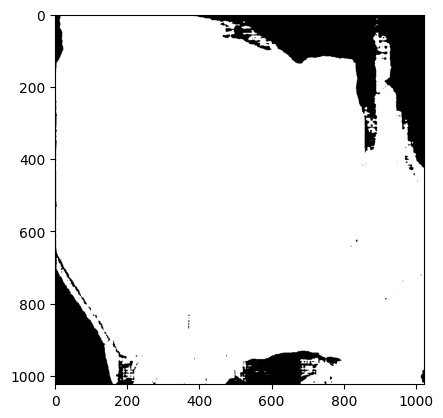

tensor(0.8844)


In [25]:
from skimage import metrics

result = None
for i, (image, path, masks) in enumerate(validloader):
    image = image[0].permute(1, 2, 0)
    print(image.shape)
    masks = masks[0]
    mask = get_totalmask(masks)
    result = inference_model(sam_lora, image, mask)
    result = result.transpose(1, 2, 0)
    plt.imshow(mask, cmap='gray')
    plt.show()
    plt.imshow(result, cmap='gray')
    plt.show()
    plt.imsave(f"/content/drive/MyDrive/Computer Vision Project/lora results/desert/{dat}{i}.jpg", result.squeeze())
    print(calculate_iou(result.squeeze(), mask.squeeze()))

# All data combined

In [23]:
robotrainloader, robovalidloader, robotestloader = load_datasets(1024, robotrain, robovalid, robotest, roboannot)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [11]:
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/highway'
train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"

trainloader1, validloader1, testloader1 = load_datasets(1024, train, valid, test, annot)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/construction'
train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"

trainloader2, validloader2, testloader2 = load_datasets(1024, train, valid, test, annot)

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [13]:
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/desert'
train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"

trainloader3, validloader3, testloader3 = load_datasets(1024, train, valid, test, annot)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [14]:
import torch
from torch.utils.data import ConcatDataset, DataLoader

# Assuming the datasets for each loader are accessible as .dataset
# If they are not, you will need to adjust this part to correctly reference your datasets

# Combine training datasets
combined_train_dataset = ConcatDataset([trainloader1.dataset, trainloader2.dataset, trainloader3.dataset])

# Combine validation datasets
combined_valid_dataset = ConcatDataset([validloader1.dataset, validloader2.dataset, validloader3.dataset])

# Combine test datasets
combined_test_dataset = ConcatDataset([testloader1.dataset, testloader2.dataset, testloader3.dataset])

# Create new data loaders from combined datasets
trainloader = DataLoader(combined_train_dataset, batch_size=1, shuffle=True)
validloader = DataLoader(combined_valid_dataset, batch_size=1, shuffle=False)
testloader = DataLoader(combined_test_dataset, batch_size=1, shuffle=False)

In [28]:
# Test images are comign with shape of H x W x 4 for some reason
for i, (image, path, masks) in enumerate(validloader):
    img = image[0].permute(1, 2, 0).numpy()
    # plt.imshow(img)
    # plt.show()
    msk = get_totalmask(masks[0]).numpy()
    # plt.imshow(msk, cmap="gray")
    # plt.show()
    plt.imsave(f"/content/Sam_LoRA/dataset/test/images/{dat}{i}.jpg", img)
    plt.imsave(f"/content/Sam_LoRA/dataset/test/masks/{dat}{i}.jpg", msk)

for i, (image, path, masks) in enumerate(trainloader):
    img = image[0].permute(1, 2, 0).numpy()
    # plt.imshow(img)
    # plt.show()
    msk = get_totalmask(masks[0]).numpy()
    # plt.imshow(msk, cmap="gray")
    # plt.show()
    plt.imsave(f"/content/Sam_LoRA/dataset/train/images/{dat}{i}.jpg", img)
    plt.imsave(f"/content/Sam_LoRA/dataset/train/masks/{dat}{i}.jpg", msk)

In [17]:
untrained = ModelSimple()
untrained.setup()
untrained.to(DEVICE)
untrained.eval()
print("Done")

freeze_layers = [100, 50, 10]

for i in freeze_layers:
    print(f"----------- Freeze percentage {i} (Only the last nth percentage of weights are trainable)-------------")
    model = ModelSimple(freeze_percentage=True, percentage=i)
    model.setup()
    model.to(DEVICE)
    model.train()

    model, bestlosses, bestious, losses, ious = training(model, trainloader, validloader)
    print(f"Regular ious: {ious}")
    print(f"Best ious: {bestious}")
    display_results(model, untrained, validloader, 82)
    if i in [100, 50, 10]:
        display_results(model, untrained, robovalidloader, 82)
    plot_results(losses, ious)
    print("-------------------------------------------------------------------------------------------------------")

Output hidden; open in https://colab.research.google.com to view.

In [29]:
%%capture
!poetry config virtualenvs.in-project false
!poetry install --all-extras
!poetry run pip install --upgrade torch torchvision gradio safetensors opencv-python monai
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [30]:
!poetry run python train.py

100% 34/34 [00:13<00:00,  2.61it/s]
EPOCH: 0
Mean loss training: 1.2376079068464392
100% 34/34 [00:12<00:00,  2.72it/s]
EPOCH: 1
Mean loss training: 1.0580616120029898
100% 34/34 [00:12<00:00,  2.70it/s]
EPOCH: 2
Mean loss training: 1.028738460120033
100% 34/34 [00:12<00:00,  2.71it/s]
EPOCH: 3
Mean loss training: 0.9959849504863515
100% 34/34 [00:12<00:00,  2.71it/s]
EPOCH: 4
Mean loss training: 0.9708286786780638
100% 34/34 [00:12<00:00,  2.71it/s]
EPOCH: 5
Mean loss training: 0.9563304729321424
100% 34/34 [00:12<00:00,  2.71it/s]
EPOCH: 6
Mean loss training: 0.9476796371095321
100% 34/34 [00:12<00:00,  2.71it/s]
EPOCH: 7
Mean loss training: 0.9424499571323395
100% 34/34 [00:12<00:00,  2.71it/s]
EPOCH: 8
Mean loss training: 0.9407936369671541
100% 34/34 [00:12<00:00,  2.71it/s]
EPOCH: 9
Mean loss training: 0.9380710493115818


In [31]:
import torch
import numpy as np
from src.segment_anything import build_sam_vit_b, SamPredictor, sam_model_registry
from src.processor import Samprocessor
from src.lora import LoRA_sam
from PIL import Image
import matplotlib.pyplot as plt
import src.utils as utils
from PIL import Image, ImageDraw
import yaml
import json
from torchvision.transforms import ToTensor

"""
This file is used to plots the predictions of a model (either baseline or LoRA) on the train or test set. Most of it is hard coded so I would like to explain some parameters to change
referencing by lines :
line 22: change the rank of lora; line 98: Do inference on train (inference_train=True) else on test; line 101 and 111 is_baseline arguments in fuction: True to use baseline False to use LoRA model.
"""
sam_checkpoint = "sam_vit_b_01ec64.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = build_sam_vit_b(checkpoint=sam_checkpoint)
rank = 512
sam_lora = LoRA_sam(sam, rank)
sam_lora.load_lora_parameters(f"./lora_rank{rank}.safetensors")
model = sam_lora.sam


def inference_model(sam_model, img, mask, is_baseline=False):
    if is_baseline == False:
        model = sam_model.sam
        rank = sam_model.rank
    else:
        model = build_sam_vit_b(checkpoint=sam_checkpoint)

    model.eval()
    model.to(device)
    image = img
    # mask = mask.convert('1')
    ground_truth_mask =  np.array(mask)
    box = utils.get_bounding_box(ground_truth_mask)

    predictor = SamPredictor(model)
    predictor.set_image(np.array(image))
    masks, iou_pred, low_res_iou = predictor.predict(
        box=np.array(box),
        multimask_output=False,
    )

    return masks

torch.Size([1024, 1024, 3])


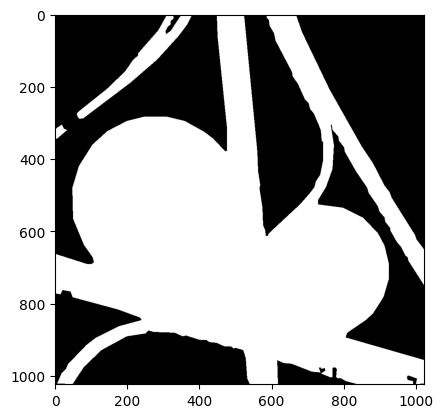

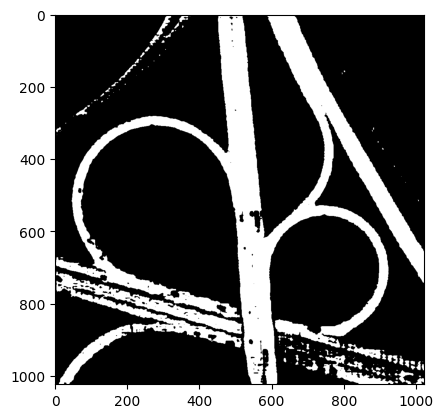

tensor(0.4203)
torch.Size([1024, 1024, 3])


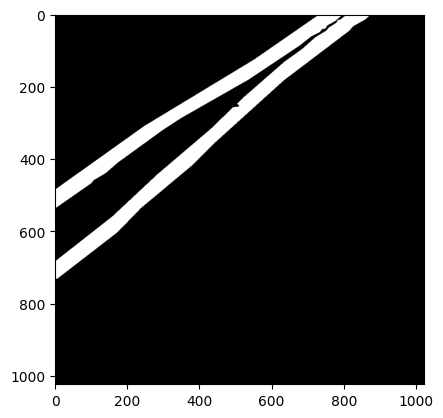

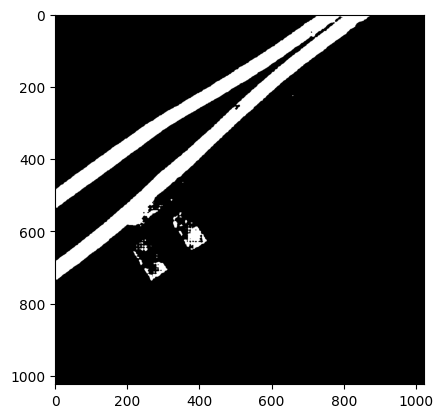

tensor(0.8777)
torch.Size([1024, 1024, 3])


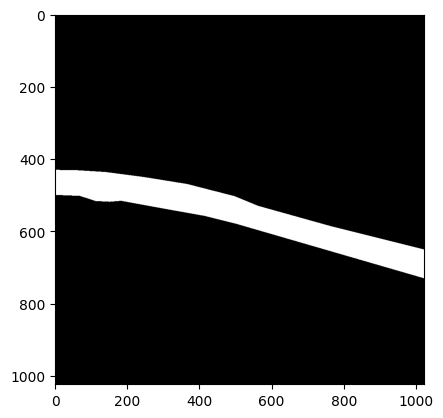

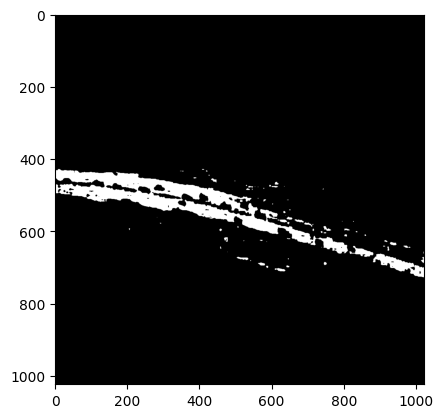

tensor(0.5491)
torch.Size([1024, 1024, 3])


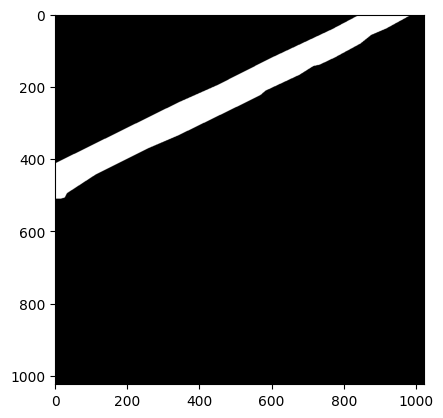

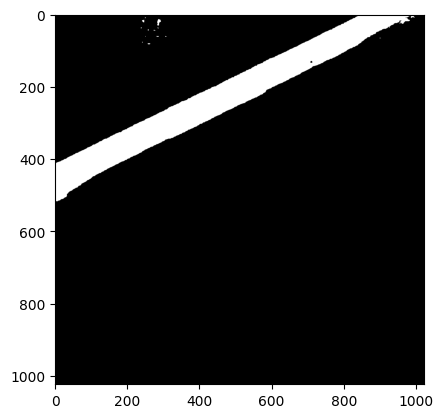

tensor(0.9667)
torch.Size([1024, 1024, 3])


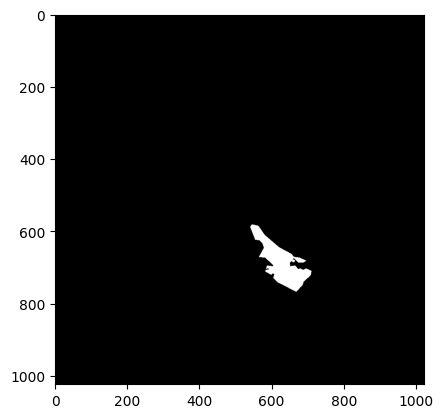

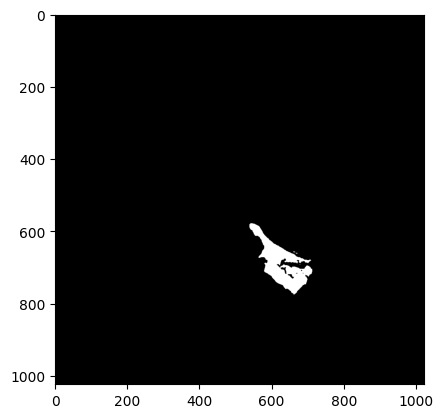

tensor(0.7904)
torch.Size([1024, 1024, 3])


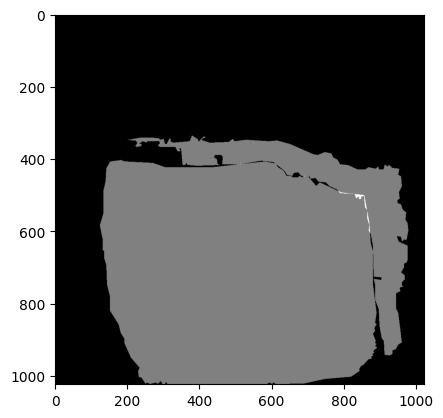

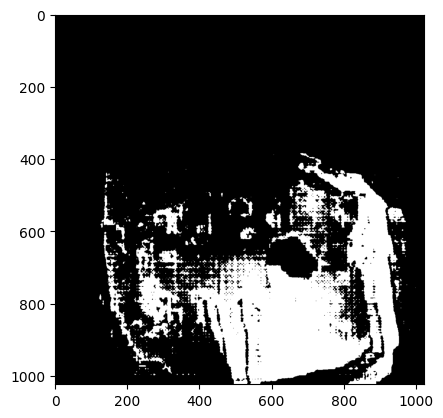

tensor(0.3999)
torch.Size([1024, 1024, 3])


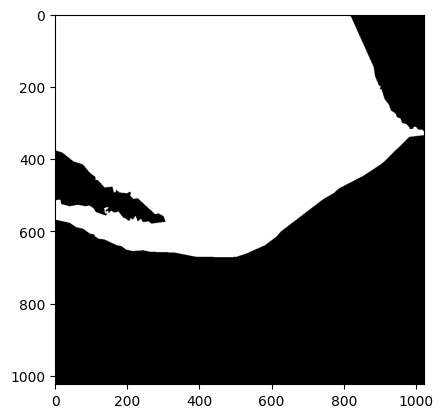

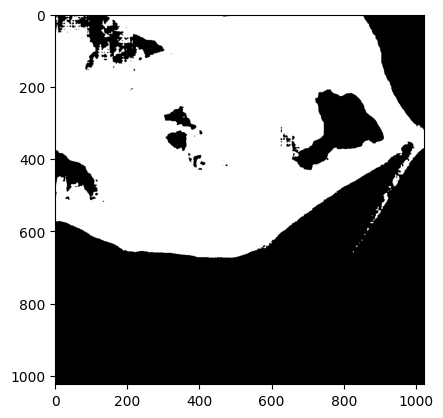

tensor(0.8512)
torch.Size([1024, 1024, 3])


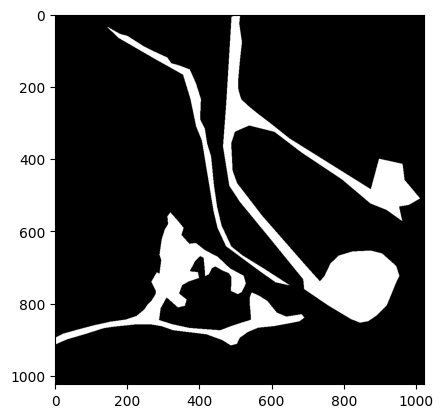

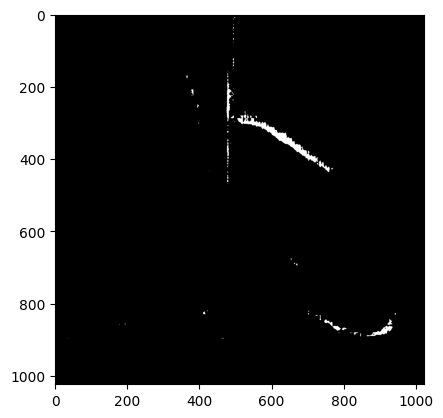

tensor(0.0318)
torch.Size([1024, 1024, 3])


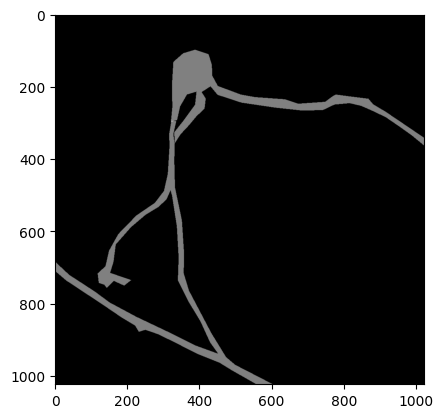

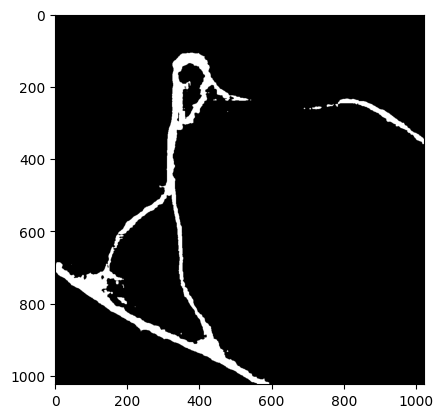

tensor(0.5805)


In [32]:
from skimage import metrics

result = None
for i, (image, path, masks) in enumerate(validloader):
    image = image[0].permute(1, 2, 0)
    print(image.shape)
    masks = masks[0]
    mask = get_totalmask(masks)
    result = inference_model(sam_lora, image, mask)
    result = result.transpose(1, 2, 0)
    plt.imshow(mask, cmap='gray')
    plt.show()
    plt.imshow(result, cmap='gray')
    plt.show()
    plt.imsave(f"/content/drive/MyDrive/Computer Vision Project/lora results/desert/{dat}{i}.jpg", result.squeeze())
    print(calculate_iou(result.squeeze(), mask.squeeze()))

In [5]:
!pip freeze > requirements.txt